# `Введение в Эффективные Системы Машинного обучения`

## `Задание 01. Умножение векторов и матриц с использованием CUDA`.

#### Фамилия, имя:

Дата выдачи: <span style="color:red">__9 сентября__</span>.

Мягкий дедлайн: <span style="color:red">__22 сентября 05:00__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __3 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2025`

##### По всем вопросам писать `@trandelik`

## `Введение`

В рамках этого задания вам предстоит познакомиться с основами программирования на GPU, чтобы лучше разобраться в их устройстве. Для этого мы воспользуемся библиотекой Numba, которая позволяет писать CUDA-кернелы прямо на Python. Несмотря на это, опыт написания кернелов на Numba напрямую переносится на C++ CUDA в силу схожих интерфейсов, при этом требует более низкого порога входа.

Документация [Numba CUDA Guide](https://numba.readthedocs.io/en/stable/cuda/index.html)

При составлении задания авторы сильно вдохновлялись [GPU puzzles](https://github.com/srush/GPU-Puzzles)

**Важно:** авторы настоятельно рекомендуют выполнять домашнее задание в Google Colab и не гарантируют поддержку других сред. Также мы приведем версии CUDA, драйверов, python и библиотек ниже.

In [ ]:
!nvidia-smi

Tue Sep  9 12:05:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


## `Setup`

In [ ]:
!pip install numba-cuda==0.4.0


from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: numba-cuda
    Found existing installation: numba-cuda 0.11.0
    Uninstalling numba-cuda-0.11.0:
      Successfully uninstalled numba-cuda-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires numba-cuda<0.12.0a0,>=0.11.0, but you have numba-cuda 0.4.0 which is incompatible.


In [ ]:
import numba
from numba import cuda
import numpy as np
import torch
import timeit
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

warnings.filterwarnings(
    action="ignore", category=numba.NumbaPerformanceWarning, module="numba"
)

sns.set_theme(style="whitegrid")
%config InlineBackend.figure_format = 'svg'

In [ ]:
print("Python version:", sys.version)
print("Numba version:", numba.__version__)
print("Numpy version:", np.__version__)
print("Torch version:", torch.__version__)

Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Numba version: 0.60.0
Numpy version: 2.0.2
Torch version: 2.8.0+cu126


## `Часть 1. Скалярное произведение векторов (4 балла)`

### `Testing Utils`

Мы подготовили тестовую функцию, которая поможет проверить корректность ваших реализаций и измерить их производительность. Она будет собирать данные о времени выполнения, чтобы мы могли построить красивые графики.

In [ ]:
dot_product_results = []

def test_dot_product(custom_function, name, full_bench=True):
    print(f"--- Testing: {name} ---")
    # Test 1: Простой тест для векторов
    a = np.array([1, 2, 3], dtype=np.float32)
    b = np.array([4, 5, 6], dtype=np.float32)
    expected = a @ b
    result = custom_function(a, b)
    assert np.allclose(result, expected), f"Test 1 failed: {result} != {expected}"

    # Test 2: Тест с нулевым вектором
    z = np.zeros(5, dtype=np.float32)
    c = np.array([1, 2, 3, 4, 5], dtype=np.float32)
    expected = z @ c
    result = custom_function(z, c)
    assert np.allclose(result, expected), f"Test 2 failed: {result} != {expected}"

    # Test 3: Случайные векторы разных размеров
    shapes = [10, 101, 1000]
    for i, shape in enumerate(shapes):
        np.random.seed(i)
        a = np.random.rand(shape).astype(np.float32)
        b = np.random.rand(shape).astype(np.float32)
        expected = a @ b
        result = custom_function(a, b)
        assert np.allclose(result, expected, atol=1e-5), f"Test 3 (shape={shape}) failed"
    print("All tests passed!")

    # Бенчмарки
    print("Benchmarking...")
    sizes = [1_000, 10_000, 100_000, 1_000_000]
    if full_bench:
        sizes.append(10_000_000)

    for size in sizes:
        np.random.seed(42)
        a = np.random.rand(size).astype(np.float32)
        b = np.random.rand(size).astype(np.float32)

        # Прогрев (первый запуск может быть медленным из-за компиляции)
        custom_function(a,b)

        times = timeit.repeat(lambda: custom_function(a, b), number=10, repeat=3)
        times = np.array(times)
        mean_time = times.mean()
        std_time = times.std()

        dot_product_results.append({
            "name": name,
            "size": size,
            "mean_time": mean_time,
            "std_time": std_time
        })
        print(f"Size={size}:\t{mean_time:.6f} ± {std_time:.6f} seconds")
    print("Done.\n")

### `Baselines`

In [ ]:
def naive_dot(a, b):
    result = 0.0
    for i in range(a.shape[0]):
        result += a[i] * b[i]
    return result

def numpy_dot(a, b):
    return a @ b

def torch_dot(a, b):
    # Мы живем в мире "посчитай скалярное произведение этих двух numpy векторов"
    # Поэтому время перекладывания на GPU тоже надо учитывать
    a_device = torch.from_numpy(a).cuda()
    b_device = torch.from_numpy(b).cuda()
    result_cuda = torch.dot(a_device, b_device)
    return result_cuda.cpu().numpy()

In [ ]:
test_dot_product(naive_dot, "Python Loop", full_bench=False)
test_dot_product(numpy_dot, "Numpy")
test_dot_product(torch_dot, "PyTorch")

--- Testing: Python Loop ---
All tests passed!
Benchmarking...
Size=1000:	0.003021 ± 0.000178 seconds
Size=10000:	0.030350 ± 0.001879 seconds
Size=100000:	0.297175 ± 0.011585 seconds
Size=1000000:	3.275370 ± 0.468790 seconds
Done.

--- Testing: Numpy ---
All tests passed!
Benchmarking...
Size=1000:	0.000021 ± 0.000010 seconds
Size=10000:	0.000025 ± 0.000002 seconds
Size=100000:	0.000155 ± 0.000042 seconds
Size=1000000:	0.003336 ± 0.000070 seconds
Size=10000000:	0.050245 ± 0.001240 seconds
Done.

--- Testing: PyTorch ---
All tests passed!
Benchmarking...
Size=1000:	0.000762 ± 0.000053 seconds
Size=10000:	0.001071 ± 0.000026 seconds
Size=100000:	0.003143 ± 0.000026 seconds
Size=1000000:	0.019080 ± 0.000165 seconds
Size=10000000:	0.171679 ± 0.001987 seconds
Done.



### `Задание 1. Naive GPU implementation (1 балл)`

Наша первая задача — реализовать скалярное произведение на GPU.

Здесь мы поручим каждому потоку вычислить произведение одной пары элементов `a[i] * b[i]`. Затем все эти произведения нужно как-то сложить. Самый простой способ — использовать [**атомарную операцию**](https://habr.com/ru/articles/244881/). Для этого предлагается использовать функцию `cuda.atomic.add(array, index, value)`.

In [ ]:
THREADS_PER_BLOCK = 1024

@cuda.jit
def naive_dot_product_kernel(a, b, result):
    '''
    Кернел, вычисляющий скалярное произведение векторов a и b и
    записывающий его в нулевую позицию вектора result.
    Для вычисления суммы используется atomic.add
    '''

    ### YOUR CODE HERE



def dot_product_naive_gpu(a, b):
    '''
    Функция, принимающая на вход два numpy массива и вычисляющая их скалярное произведение,
    используя naive_dot_product_kernel
    '''
    # Создаем на CPU массив для хранения результата
    result_host = np.array([0], dtype=a.dtype)

    # Копируем данные на GPU
    ### YOUR CODE HERE

    # Вычисляем, сколько блоков нам нужно для всех элементов вектора
    ### YOUR CODE HERE

    # Запускаем кернел
    ### YOUR CODE HERE

    # Копируем результат обратно на CPU
    ### YOUR CODE HERE

    return result_host[0]

In [ ]:
test_dot_product(dot_product_naive_gpu, "Naive GPU")

--- Testing: Naive GPU ---
All tests passed!
Benchmarking...
Size=1000:	0.006864 ± 0.000056 seconds
Size=10000:	0.007989 ± 0.000591 seconds
Size=100000:	0.013757 ± 0.001150 seconds
Size=1000000:	0.066871 ± 0.001551 seconds
Size=10000000:	0.408135 ± 0.022108 seconds
Done.



### `Задание 2. Smarter GPU implementation with Shared Memory (1 балл)`

Прошлая реализация проста, но крайне неэффективна. Атомарные операции создают "бутылочное горлышко", заставляя все потоки синхронизироваться при записи в глобальную память.

Чтобы это исправить, мы воспользуемся `shared memory` — сверхбыстрой памятью, доступной для всех потоков **внутри одного блока**. Алгоритм будет таким:

1.  Каждый поток вычисляет свое произведение `a[idx] * b[idx]`.
2.  Результат сохраняется в массив `s_data` в `shared memory`.
3.  **Синхронизируем все потоки в блоке** с помощью `cuda.syncthreads()`. Это гарантия того, что все потоки закончили шаг 2, прежде чем кто-то перейдет к шагу 4.
4.  Один поток (например, с `local_idx == 0`) проходит по всему массиву `s_data` и суммирует его значения.
5.  Этот же поток атомарно добавляет сумму своего блока к общему результату в глобальной памяти.

Теперь у нас всего одна синхронизация на блок, а не на каждый элемент, что должно быть гораздо быстрее.

In [ ]:
THREADS_PER_BLOCK = 1024

@cuda.jit
def shmem_dot_product_kernel(a, b, result):
    '''
    Кернел, вычисляющий скалярное произведение векторов a и b и
    записывающий его в нулевую позицию вектора result.
    Для вычисления суммы используется shared memory
    и последующее суммирование значений одним потоком
    '''
    # Создаем массив в shared memory
    ### YOUR CODE HERE

    # Глобальный и локальный (внутри блока) индексы
    ### YOUR CODE HERE

    # 1. Каждый поток считает произведение и записывает в shared memory
    ### YOUR CODE HERE

    # 2. Один поток (нулевой) суммирует все, что есть в shared memory,
    # и атомарно добавляет к итоговому результату.
    ### YOUR CODE HERE


def dot_product_shmem(a, b):
    '''
    Функция, принимающая на вход два numpy массива и вычисляющая их скалярное произведение,
    используя shmem_dot_product_kernel
    '''
    ### Аналогично функции из прошлого пункта
    ### YOUR CODE HERE


In [ ]:
test_dot_product(dot_product_shmem, "Shared Memory")

--- Testing: Shared Memory ---
All tests passed!
Benchmarking...
Size=1000:	0.016714 ± 0.004918 seconds
Size=10000:	0.014854 ± 0.002448 seconds
Size=100000:	0.018346 ± 0.000163 seconds
Size=1000000:	0.067118 ± 0.003372 seconds
Size=10000000:	0.525902 ± 0.092171 seconds
Done.



### `Задание 3. Even More Smart GPU implementation with Parallel Reduction (2 балла)`

В предыдущем решении мы добились ускорения, но суммирование внутри блока все еще выполнялось в один поток. Это неэффективно. Ключевая особенность CUDA — параллельность, и мы можем использовать ее даже для суммирования!

Для этого применяется алгоритм **параллельной редукции (parallel reduction)**. Идея в том, чтобы на каждой итерации складывать пары элементов, уменьшая массив вдвое, пока не останется один элемент — сумма.

Пример для 8 элементов:
1.  `[1, 2, 3, 4, 5, 6, 7, 8]`
2.  Потоки 0-3 складывают элементы с потоками 4-7: `s_data[i] += s_data[i + 4]`.
    Результат: `[6, 8, 10, 12, ...]`
3.  Потоки 0-1 складывают элементы с потоками 2-3: `s_data[i] += s_data[i + 2]`.
    Результат: `[16, 20, ...]`
4.  Поток 0 складывает элемент с потоком 1: `s_data[0] += s_data[1]`.
    Результат: `[36, ...]`

In [ ]:
THREADS_PER_BLOCK = 1024

@cuda.jit
def reduce_dot_product_kernel(a, b, result):
    '''
    Кернел, вычисляющий скалярное произведение векторов a и b и
    записывающий его в нулевую позицию вектора result.
    Для вычисления суммы используется shared memory
    и алгоритм параллельной редукции
    '''

    # 1. Загружаем данные в shared memory (как в прошлом задании)
    ### YOUR CODE HERE

    # 2. Реализуем параллельную редукцию.
    # YOUR CODE HERE

    # 3. Нулевой поток записывает итоговую сумму
    ### YOUR CODE HERE


def dot_product_reduce(a, b):
    '''
    Функция, принимающая на вход два numpy массива и вычисляющая их скалярное произведение,
    используя reduce_dot_product_kernel
    '''
    ### Аналогично функции из прошлого пункта
    ### YOUR CODE HERE


In [ ]:
test_dot_product(dot_product_reduce, "Parallel Reduce")

--- Testing: Parallel Reduce ---
All tests passed!
Benchmarking...
Size=1000:	0.007644 ± 0.000729 seconds
Size=10000:	0.007072 ± 0.000071 seconds
Size=100000:	0.009362 ± 0.000076 seconds
Size=1000000:	0.037380 ± 0.004318 seconds
Size=10000000:	0.217794 ± 0.005239 seconds
Done.



### `Сравнение результатов`

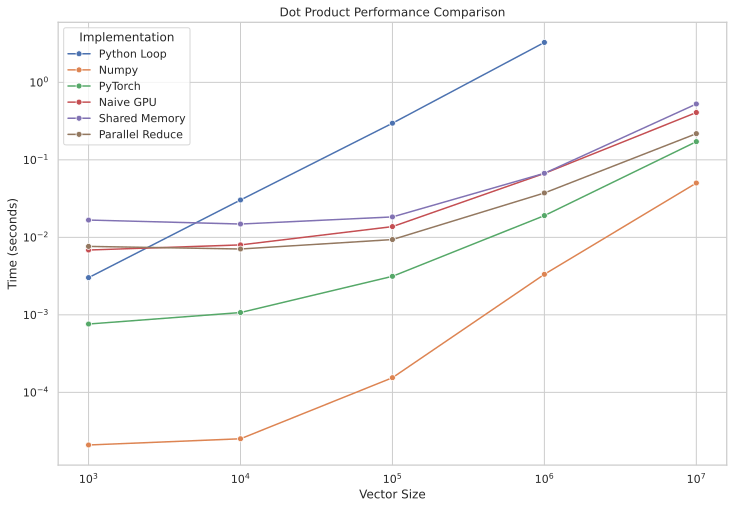

In [ ]:
df_dot = pd.DataFrame(dot_product_results)

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_dot, x='size', y='mean_time', hue='name', marker='o')
plt.title('Dot Product Performance Comparison')
plt.xlabel('Vector Size')
plt.ylabel('Time (seconds)')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Implementation')
plt.show()

**Выводы**:

## `Часть 2. Перемножение матриц (6 баллов)`

### `Testing utils`

In [ ]:
matmul_results = []

def test_matrix_multiplication(custom_function, name, full_bench=True):
    print(f"--- Testing: {name} ---")

    # Test 1: Простые 2x2 матрицы
    A = np.array([[1, 2], [3, 4]], dtype=np.float32)
    B = np.array([[5, 6], [7, 8]], dtype=np.float32)
    expected = A @ B
    result = custom_function(A, B)
    assert np.allclose(result, expected), f"Test 1 failed: \n{result} \n!= \n{expected}"

    # Test 2: Умножение на единичную матрицу
    I = np.eye(3, dtype=np.float32)
    C = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=np.float32)
    expected = I @ C
    result = custom_function(I, C)
    assert np.allclose(result, expected), f"Test 2 failed"

    # Test 3: Неквадратные матрицы
    A = np.array([[1, 2, 3], [4, 5, 6]], dtype=np.float32) # 2x3
    B = np.array([[7, 8], [9, 10], [11, 12]], dtype=np.float32) # 3x2
    expected = A @ B
    result = custom_function(A, B)
    assert np.allclose(result, expected), f"Test 3 failed"

    # Test 4: Случайные матрицы
    shapes = [(13, 5, 17), (32, 64, 32), (100, 100, 100)]
    for i, (M, K, N) in enumerate(shapes):
        np.random.seed(i)
        A = np.random.rand(M, K).astype(np.float32)
        B = np.random.rand(K, N).astype(np.float32)
        expected = A @ B
        result = custom_function(A, B)
        assert np.allclose(result, expected, atol=1e-5), f"Test 4 failed for shape {(M,K,N)}"

    print("All tests passed!")

    # Бенчмарки
    print("Benchmarking...")
    sizes = [32, 64]
    if full_bench:
        sizes.extend([128, 256, 512, 1024, 2048, 4096])

    for size in sizes:
        np.random.seed(42)
        A = np.random.rand(size, size).astype(np.float32)
        B = np.random.rand(size, size).astype(np.float32)

        custom_function(A, B) # Прогрев

        times = timeit.repeat(lambda: custom_function(A, B), number=10, repeat=3)
        times = np.array(times)
        mean_time = times.mean()
        std_time = times.std()

        matmul_results.append({
            "name": name,
            "size": size,
            "mean_time": mean_time,
            "std_time": std_time
        })
        print(f"Size={size}x{size}:\t{mean_time:.6f} ± {std_time:.6f} seconds")
    print("Done.\n")

### `Baselines`

In [ ]:
def naive_matmul(A, B):
    result = np.zeros((A.shape[0], B.shape[1]), dtype=np.float32)
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                result[i, j] += A[i, k] * B[k, j]
    return result

def numpy_matmul(A, B):
    return A @ B

def torch_matmul(A, B):
    A_device = torch.from_numpy(A).cuda()
    B_device = torch.from_numpy(B).cuda()
    result_cuda = A_device @ B_device
    return result_cuda.cpu().numpy()

In [ ]:
test_matrix_multiplication(naive_matmul, "Python Loop", full_bench=False)
test_matrix_multiplication(numpy_matmul, "Numpy")
test_matrix_multiplication(torch_matmul, "PyTorch")

--- Testing: Python Loop ---
All tests passed!
Benchmarking...
Size=32x32:	0.187895 ± 0.005568 seconds
Size=64x64:	1.761727 ± 0.351006 seconds
Done.

--- Testing: Numpy ---
All tests passed!
Benchmarking...
Size=32x32:	0.000061 ± 0.000005 seconds
Size=64x64:	0.000194 ± 0.000012 seconds
Size=128x128:	0.000667 ± 0.000002 seconds
Size=256x256:	0.004414 ± 0.000119 seconds
Size=512x512:	0.032187 ± 0.000315 seconds
Size=1024x1024:	0.251044 ± 0.011845 seconds
Size=2048x2048:	2.399677 ± 0.603713 seconds
Size=4096x4096:	17.649226 ± 0.503615 seconds
Done.

--- Testing: PyTorch ---
All tests passed!
Benchmarking...
Size=32x32:	0.000973 ± 0.000040 seconds
Size=64x64:	0.001092 ± 0.000024 seconds
Size=128x128:	0.001714 ± 0.000131 seconds
Size=256x256:	0.004741 ± 0.001161 seconds
Size=512x512:	0.013615 ± 0.001384 seconds
Size=1024x1024:	0.041167 ± 0.005463 seconds
Size=2048x2048:	0.160740 ± 0.009388 seconds
Size=4096x4096:	1.006009 ± 0.010275 seconds
Done.



### `Задание 4. Dot product based solution (1 балл)`

Каждый элемент `C[i, j]` результирующей матрицы `C` является скалярным произведением i-й строки матрицы `A` и j-го столбца матрицы `B`. У нас уже есть быстрая реализация скалярного произведения с помощью `dot_product_reduce`. Давайте воспользуемся ей.

In [ ]:
THREADS_PER_BLOCK = 1024

def matmul_dot_based_gpu(A, B):
    '''
    Функция, вычисляющая произведение матриц A и B путем вычисления
    скалярных произведений с помощью dot_product_reduce
    '''
    M, K = A.shape
    K, N = B.shape
    C = np.empty((M, N), dtype=A.dtype)
    B_T = np.ascontiguousarray(B.T)

    ### YOUR CODE HERE

    return C

In [ ]:
test_matrix_multiplication(matmul_dot_based_gpu, "Dot-based GPU", full_bench=False)

--- Testing: Dot-based GPU ---
All tests passed!
Benchmarking...
Size=32x32:	8.897457 ± 1.701555 seconds
Size=64x64:	31.100262 ± 0.164575 seconds
Done.



### `Задание 5. A better way: one kernel for the whole matrix (2 балла)`

**Проблема:** Прошлый подход ужасно неэффективен. На каждый элемент `C[i, j]` мы будем заново запускать CUDA-кернел. Запуск кернела — дорогая операция. Мы делаем `M*N` запусков, каждый из которых несет большие накладные расходы.

Давайте напишем один кернел, который вычислит всю матрицу `C` за один раз.

Для этого мы будем использовать **двумерный грид блоков и двумерные блоки потоков**. Каждому потоку мы поручим вычислить ровно один элемент `C[i,j]` результирующей матрицы.

In [ ]:
THREADS_PER_BLOCK_2D = (32, 32)

@cuda.jit
def matmul_kernel(A, B, C):
    '''
    Кернел, вычисляющий произведение матриц A и B и
    записывающий его в матрицу C.
    Для вычисления произведения каждый поток вычисляет C[i, j] элемент матрицы C
    '''

    # 1. Получаем глобальные индексы (i, j) для результирующей матрицы C
    ### YOUR CODE HERE

    # 2. Вычисляем скалярное произведение A[i, :] и B[:, j]
    ### YOUR CODE HERE


def matmul_naive_gpu(A, B):
    '''
    Функция, принимающая на вход два 2D numpy массива и вычисляющая их произведение,
    используя matmul_kernel
    '''
    # Аллоцируем память под результат
    ### YOUR CODE HERE

    # Копируем данные на GPU
    ### YOUR CODE HERE

    # Вычисляем размер сетки
    ### YOUR CODE HERE

    # Запускаем kernel
    ### YOUR CODE HERE

    # Возвращаем результат
    ### YOUR CODE HERE

In [ ]:
test_matrix_multiplication(matmul_naive_gpu, "Naive Matmul GPU")

--- Testing: Naive Matmul GPU ---
All tests passed!
Benchmarking...
Size=32x32:	0.013095 ± 0.002587 seconds
Size=64x64:	0.012267 ± 0.000612 seconds
Size=128x128:	0.016029 ± 0.001708 seconds
Size=256x256:	0.035916 ± 0.000506 seconds
Size=512x512:	0.108696 ± 0.018392 seconds
Size=1024x1024:	0.433090 ± 0.003514 seconds
Size=2048x2048:	3.399615 ± 0.014184 seconds
Size=4096x4096:	27.323093 ± 0.233155 seconds
Done.



### `Задание 6. Efficient Matmul with Tiling (3 балла)`

Предыдущее решение работает, но оно все еще неоптимально. Главный недостаток — огромное количество **повторных чтений из глобальной памяти**. Каждый поток, вычисляющий `C[i, j]`, читает всю i-ю строку `A` и весь j-й столбец `B`. При этом соседний поток, вычисляющий `C[i, j+1]`, будет заново читать ту же самую i-ю строку `A`.

Чтение из глобальной памяти — самая медленная операция на GPU. Чтобы ее минимизировать, мы применим **тайловое умножение (tiled matrix multiplication)**.

**Алгоритм:**

1.  Мысленно разбиваем матрицы A и B на небольшие подматрицы (тайлы), размером с блок потоков (например, 16x16).
2.  **Блок потоков** совместно загружает один тайл из матрицы `A` и один тайл из матрицы `B` в быструю **`shared memory`**.
3.  **Синхронизация.** Ждем, пока все потоки блока закончат загрузку.
4.  Каждый поток в блоке вычисляет часть своего итогового значения `C[i,j]`, используя **только данные из `shared memory`**. Это очень быстро.
5.  Повторяем шаги 2-4 для всех пар тайлов, которые влияют на результирующий тайл матрицы `C`, и накапливаем сумму в локальной переменной (регистре).
6.  В самом конце каждый поток записывает накопленное значение в `C[i, j]` в глобальную память.

Таким образом, каждый элемент матриц A и B загружается из глобальной памяти всего один раз за итерацию по тайлам, а затем многократно переиспользуется из сверхбыстрой `shared memory`.

![Tiled Matrix Multiplication](https://cnugteren.github.io/tutorial/images/gemm2a.png)

In [ ]:
TILE_SIZE = 32


@cuda.jit
def efficient_matmul_kernel(A, B, C):
    '''
    Кернел, вычисляющий произведение матриц A и B и
    записывающий его в матрицу C.
    Для вычисления произведения используется tiled matrix multiplication алгоритм
    '''
    # 1. Объявляем тайлы в shared memory и вычисляем индексы
    ### YOUR CODE HERE

    # 2. Переменная-аккумулятор для хранения частичной суммы C[i,j] (в регистрах)
    accumulator = 0.0

    # 3. Проходим по тайлам матриц A и B
    ### YOUR CODE HERE
    n_tiles = ...
    for tile in range(n_tiles):
        # 4. Каждый поток загружает один элемент из глобальной памяти в shared memory,
        # если индексы корректны
        ### YOUR CODE HERE

        # 5. Вычисляем произведение загруженных тайлов, результат накапливаем в `accumulator`
        ### YOUR CODE HERE

    # 6. Записываем результат в глобальную память
    ### YOUR CODE HERE


def efficient_matmul(A, B):
    '''
    Функция, принимающая на вход два 2D numpy массива и вычисляющая их  произведение,
    используя efficient_matmul_kernel
    '''
    ### Аналогично функции из прошлого пункта
    ### YOUR CODE HERE


In [ ]:
test_matrix_multiplication(efficient_matmul, "Tiled Matmul GPU")

--- Testing: Tiled Matmul GPU ---
All tests passed!
Benchmarking...
Size=32x32:	0.010223 ± 0.000141 seconds
Size=64x64:	0.009128 ± 0.000368 seconds
Size=128x128:	0.010913 ± 0.000065 seconds
Size=256x256:	0.021552 ± 0.000251 seconds
Size=512x512:	0.086343 ± 0.014685 seconds
Size=1024x1024:	0.261597 ± 0.009520 seconds
Size=2048x2048:	1.830161 ± 0.011058 seconds
Size=4096x4096:	13.606970 ± 0.038783 seconds
Done.



### `Сравнение результатов`

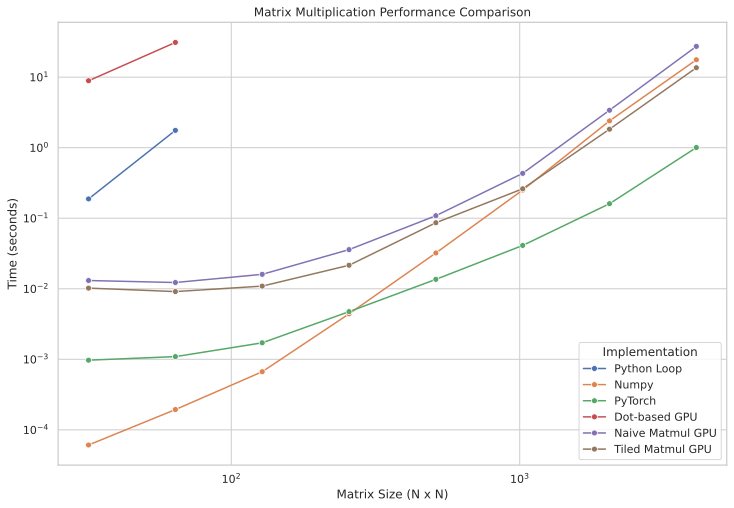

In [ ]:
df_matmul = pd.DataFrame(matmul_results)

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_matmul, x='size', y='mean_time', hue='name', marker='o')
plt.title('Matrix Multiplication Performance Comparison')
plt.xlabel('Matrix Size (N x N)')
plt.ylabel('Time (seconds)')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Implementation')
plt.show()

**Выводы**:

### `Почему PyTorch все равно быстрее?`

Вы могли заметить, что даже наша самая лучшая реализация (`Tiled Matmul GPU`) все еще уступает `PyTorch` и `Numpy`. Почему так происходит?

1.  **Специализированные библиотеки (cuBLAS):** PyTorch и другие фреймворки для умножения матриц на GPU используют не свои кернелы, а вызывают функции из библиотеки **cuBLAS**. Это высокооптимизированная, написанная инженерами NVIDIA библиотека для линейной алгебры. Она учитывает все особенности конкретной архитектуры GPU (размер кэшей, количество регистров на поток, особенности планировщика варпов и т.д.).

2.  **Низкоуровневые оптимизации:** Кернелы в cuBLAS написаны на CUDA C++ и часто содержат ассемблерные вставки для достижения максимальной производительности. Они используют более продвинутые техники, чем простое тайлирование: например, более сложное управление регистрами, двойную буферизацию для скрытия задержек памяти и др.

3.  **Оверхед Numba:** Numba — это удобный инструмент, но он вносит небольшой оверхед по сравнению с кодом, написанным непосредственно на CUDA C++. Для большинства задач это не имеет значения, но в борьбе за каждый наносекунду это может играть роль.

## `Бонусы (3 балла)`

Добавьте еще скорости! За каждое ускорение на 5 процентов относительно `efficient_matmul` на матрицах размера `4096x4096` будет добавляться по 1 баллу. Для получения балла необходимо:

1) Кратко описать идею ускорения
2) Скинуть ссылку на источник, откуда был взят прием/подробно расписать идею
3) Выполнить то же тестировани, что и раньше, нариросать график
4) **Запрещается** использовать готовые решения с использованием библиотек (например, cuBLAS)

**Важно:** Нельзя специально замедлять `efficient_matmul`. Для честного сравнения в качестве времени работы `efficient_matmul` будет использоваться минимум времени работы из Вашего решения и авторского (код будет запускаться в одной среде при проверке).